# Image Alignment from Spectral Cubes

The data in this notebook is a set of four simulated IFU cubes from David Law.  The first two dithers (Sequence 1 and 2) are aligned and the second two dithers (Sequence 3 and Sequence 4) are aligned with each other but not with Sequence 1 and 2.

Two steps will happen in here. First, all images are reprojected onto Sequence 1 (using the WCS information stored in the file). Then, the images are aligned using a few different techniques.

All of this is done using a single slice, at this point. 

In [1]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
from reproject import reproject_interp
from scipy import signal, ndimage
from image_registration import cross_correlation_shifts, chi2_shifts, register_images

Small container class defined just to store some basic info, so things don't have to be repeated.

In [2]:
class IFU(object):

    def __init__(self, filename):
        self.s3d = SpectralCube.read(filename, hdu=1)
        self._slice_number = int(self.s3d.shape[0]//2)
        
        self.spectral_slice = self.s3d[self._slice_number]
        
    def data(self, slice_number):
        spectral_slice = self.s3d[slice_number]
        data = np.array(spectral_slice)
        return data, spectral_slice.wcs

def show(data, title):
    # Display a single image with WCS projection
    pp = np.nanpercentile(data, (1, 99))
    plt.imshow(data, origin='lower', cmap=plt.gray())
    plt.clim(*pp)
    plt.grid(color='white', ls='solid')
    plt.title(title, fontsize=12)

Create a base WCS object and shifted WCS object. In code below we will change the wcs_shifted.wcs.crpix to the proper values

In [3]:
wcs = WCS(naxis=2)
wcs.wcs.ctype = ['RA---TAN', 'DEC--TAN']
wcs.wcs.crpix = [0, 0]
wcs.wcs.crval = [30, 25]
wcs.wcs.cdelt = [0.002, 0.002]
wcs.wcs.cunit = ['deg', 'deg']
wcs.wcs.equinox = 2000.

wcs_shifted = WCS(naxis=2)
wcs_shifted.wcs.ctype = ['RA---TAN', 'DEC--TAN']
wcs_shifted.wcs.crpix = [3.5, 3.5]
wcs_shifted.wcs.crval = [30, 25]
wcs_shifted.wcs.cunit = ['deg', 'deg']
wcs_shifted.wcs.cdelt = [0.002, 0.002]
wcs_shifted.wcs.equinox = 2000.

In [4]:
sl = 430

ifu1 = IFU('alldet/det_image_seq1_MIRIFUSHORT_12SHORTexp1_s3d.fits')
ifu2 = IFU('alldet/det_image_seq2_MIRIFUSHORT_12SHORTexp1_s3d.fits')
ifu3 = IFU('alldet/det_image_seq3_MIRIFUSHORT_12SHORTexp1_s3d.fits')
ifu4 = IFU('alldet/det_image_seq4_MIRIFUSHORT_12SHORTexp1_s3d.fits')

The IFU cubes are loaded up and we are going to display a single slice for each of the sequences. Given the data cubes, we know that Sequence 1 and Sequence 2 should line up.  Sequence 3 and 4 line up with each other but do not line up with Sequence 1 or 2.

This can be seen in the images below as the bright peak is shifted slightly down in the image in Sequence 3 and 4.

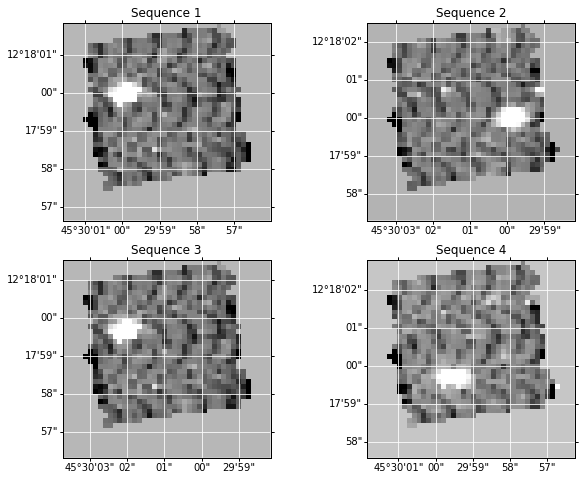

In [5]:
plt.figure(1, figsize=[10,8])

ifu1_data, ifu1_wcs = ifu1.data(sl)
plt.subplot(2,2,1, projection=ifu1_wcs)
show(ifu1_data, 'Sequence 1')

ifu2_data, ifu2_wcs = ifu2.data(sl)
plt.subplot(2,2,2, projection=ifu2_wcs)
show(ifu2_data, 'Sequence 2')

ifu3_data, ifu3_wcs = ifu3.data(sl)
plt.subplot(2,2,3, projection=ifu3_wcs)
show(ifu1_data, 'Sequence 3')

ifu4_data, ifu4_wcs = ifu4.data(sl)
plt.subplot(2,2,4, projection=ifu4_wcs)
show(ifu4_data, 'Sequence 4')


## Reproject onto a Common Grid

The next step will be to reproject them onto a common grid in order to do alignment.  To do the reprojection, the [reproject package](https://github.com/astrofrog/reproject) is used here.

For this, Sequence 2, Sequence 3 and Sequence 4 images will be reprojected onto Sequence 1.  This uses the WCS information used in each of the IFU cubes

In [6]:
ifu1_data, ifu1_wcs = ifu1.data(sl)
ifu2_data, ifu2_wcs = ifu2.data(sl)
ifu3_data, ifu3_wcs = ifu3.data(sl)
ifu4_data, ifu4_wcs = ifu4.data(sl)

ifu2_data_reproj, footprint2 = reproject_interp((ifu2_data, ifu2_wcs), ifu1_wcs, ifu1_data.shape)
ifu3_data_reproj, footprint3 = reproject_interp((ifu3_data, ifu3_wcs), ifu1_wcs, ifu1_data.shape)
ifu4_data_reproj, footprint4 = reproject_interp((ifu4_data, ifu4_wcs), ifu1_wcs, ifu1_data.shape)

# Remove nan's that crop up.
ifu2_data_reproj[~np.isfinite(ifu2_data_reproj)] = 0
ifu3_data_reproj[~np.isfinite(ifu3_data_reproj)] = 0
ifu4_data_reproj[~np.isfinite(ifu4_data_reproj)] = 0

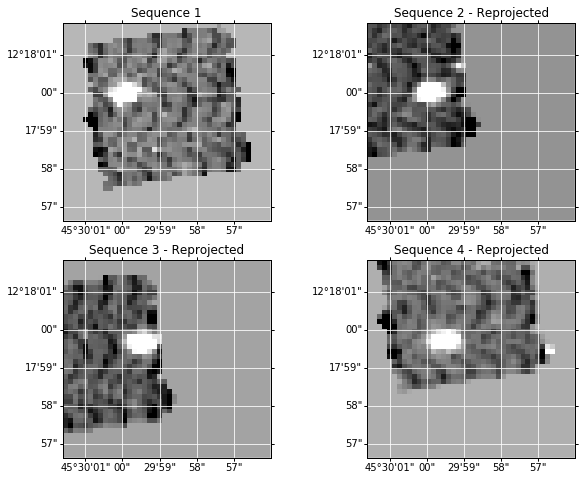

In [7]:
plt.figure(2,  figsize=[10,8])
plt.clf()
plt.subplot(221, projection=ifu1_wcs)
show(ifu1_data, 'Sequence 1')

plt.subplot(222, projection=ifu1_wcs)
show(ifu2_data_reproj, 'Sequence 2 - Reprojected')

plt.subplot(223, projection=ifu1_wcs)
show(ifu3_data_reproj, 'Sequence 3 - Reprojected')

plt.subplot(224, projection=ifu1_wcs)
show(ifu4_data_reproj, 'Sequence 4 - Reprojected')


So, as expected, Sequence 1 and 2 are still centered at the correct location, but Sequence 3 and 4 are still shifted slightly lower and to the right.  But, at this point, all the images are in the same WCS frame (Sequence 1).

## Alignment

There is a package [image-registration](https://github.com/keflavich/image_registration) written by Adam Ginsburg that he has used for alignment and regisration using cross correlation, chi2 and a third algorithm.

### Cross Correlation

In [8]:
yoff, xoff = cross_correlation_shifts(ifu2_data_reproj, ifu1_data)
print('xoff, yoff = {}, {}'.format(xoff, yoff))
wcs_shifted.wcs.crpix = [yoff, xoff]
ifu2_data_reproj_ccreg, _ = reproject_interp((ifu2_data_reproj, wcs), wcs_shifted, ifu1_data.shape)

yoff, xoff = cross_correlation_shifts(ifu3_data_reproj, ifu1_data)
print('xoff, yoff = {}, {}'.format(xoff, yoff))
wcs_shifted.wcs.crpix = [yoff, xoff]
ifu3_data_reproj_ccreg, _ = reproject_interp((ifu3_data_reproj, wcs), wcs_shifted, ifu1_data.shape)

yoff, xoff = cross_correlation_shifts(ifu4_data_reproj, ifu1_data)
print('xoff, yoff = {}, {}'.format(xoff, yoff))
wcs_shifted.wcs.crpix = [yoff, xoff]
ifu4_data_reproj_ccreg, _ = reproject_interp((ifu4_data_reproj, wcs), wcs_shifted, ifu1_data.shape)

xoff, yoff = -0.1339636515024521, 0.09114048025381241
xoff, yoff = 2.665079891087888, -3.1782831915032186
xoff, yoff = 2.370199031485678, -2.9649446569468396


/Users/crjones/miniconda3/envs/spectral_registration/lib/python3.7/site-packages/astropy/convolution/convolve.py:735: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = rifft[arrayslices].real


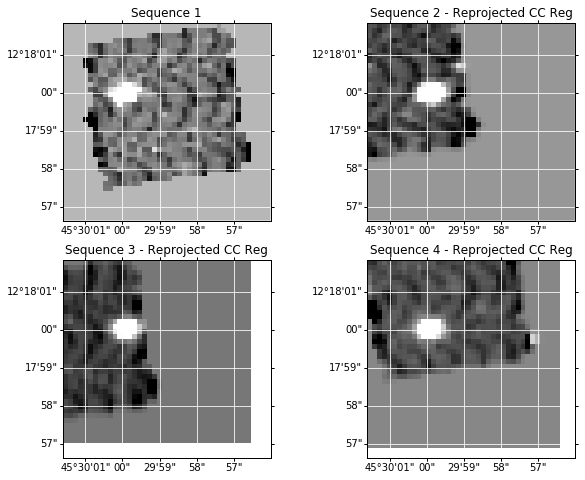

In [9]:
plt.figure(2,  figsize=[10,8])
plt.clf()
plt.subplot(221, projection=ifu1_wcs)
show(ifu1_data, 'Sequence 1')

plt.subplot(222, projection=ifu1_wcs)
show(ifu2_data_reproj_ccreg, 'Sequence 2 - Reprojected CC Reg')

plt.subplot(223, projection=ifu1_wcs)
show(ifu3_data_reproj_ccreg, 'Sequence 3 - Reprojected CC Reg')

plt.subplot(224, projection=ifu1_wcs)
show(ifu4_data_reproj_ccreg, 'Sequence 4 - Reprojected CC Reg')


### Chi2

In [10]:
yoff, xoff, edx, edy = chi2_shifts.chi2_shift(ifu2_data_reproj, ifu1_data)
print('xoff, yoff = {}, {}'.format(xoff, yoff))
wcs_shifted.wcs.crpix = [yoff, xoff]
ifu2_data_reproj_chi2, _ = reproject_interp((ifu2_data_reproj, wcs), wcs_shifted, ifu1_data.shape)

yoff, xoff, edx, edy = chi2_shifts.chi2_shift(ifu3_data_reproj, ifu1_data)
print('xoff, yoff = {}, {}'.format(xoff, yoff))
wcs_shifted.wcs.crpix = [yoff, xoff]
ifu3_data_reproj_chi2, _ = reproject_interp((ifu3_data_reproj, wcs), wcs_shifted, ifu1_data.shape)

yoff, xoff, edx, edy = chi2_shifts.chi2_shift(ifu4_data_reproj, ifu1_data)
print('xoff, yoff = {}, {}'.format(xoff, yoff))
wcs_shifted.wcs.crpix = [yoff, xoff]
ifu4_data_reproj_chi2, _ = reproject_interp((ifu4_data_reproj, wcs), wcs_shifted, ifu1_data.shape)

xoff, yoff = -0.001953125, 0.154296875
xoff, yoff = 2.310546875, -3.314453125
xoff, yoff = 2.224609375, -2.880859375


/Users/crjones/miniconda3/envs/spectral_registration/lib/python3.7/site-packages/astropy/convolution/convolve.py:735: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = rifft[arrayslices].real
/Users/crjones/miniconda3/envs/spectral_registration/lib/python3.7/site-packages/image_registration/fft_tools/zoom.py:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  outarr[ii] = outarr_d[dims]


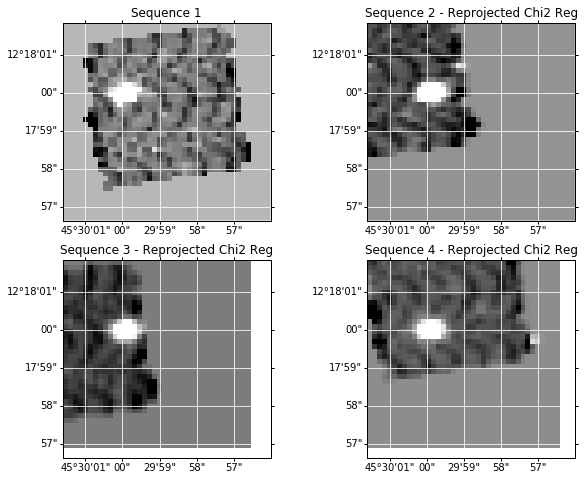

In [11]:
plt.figure(2,  figsize=[10,8])
plt.clf()
plt.subplot(221, projection=ifu1_wcs)
show(ifu1_data, 'Sequence 1')

plt.subplot(222, projection=ifu1_wcs)
show(ifu2_data_reproj_chi2, 'Sequence 2 - Reprojected Chi2 Reg')

plt.subplot(223, projection=ifu1_wcs)
show(ifu3_data_reproj_chi2, 'Sequence 3 - Reprojected Chi2 Reg')

plt.subplot(224, projection=ifu1_wcs)
show(ifu4_data_reproj_chi2, 'Sequence 4 - Reprojected Chi2 Reg')


### Sub-Pixel Image Registration

In [12]:
yoff, xoff = register_images(ifu2_data_reproj, ifu1_data)
print('xoff, yoff = {}, {}'.format(xoff, yoff))
wcs_shifted.wcs.crpix = [yoff, xoff]
ifu2_data_reproj_subpix, _ = reproject_interp((ifu2_data_reproj, wcs), wcs_shifted, ifu1_data.shape)

yoff, xoff = register_images(ifu3_data_reproj, ifu1_data)
print('xoff, yoff = {}, {}'.format(xoff, yoff))
wcs_shifted.wcs.crpix = [yoff, xoff]
ifu3_data_reproj_subpix, _ = reproject_interp((ifu3_data_reproj, wcs), wcs_shifted, ifu1_data.shape)

yoff, xoff = register_images(ifu4_data_reproj, ifu1_data)
print('xoff, yoff = {}, {}'.format(xoff, yoff))
wcs_shifted.wcs.crpix = [yoff, xoff]
ifu4_data_reproj_subpix, _ = reproject_interp((ifu4_data_reproj, wcs), wcs_shifted, ifu1_data.shape)

xoff, yoff = 0, 0
xoff, yoff = 2, -3
xoff, yoff = 2, -3


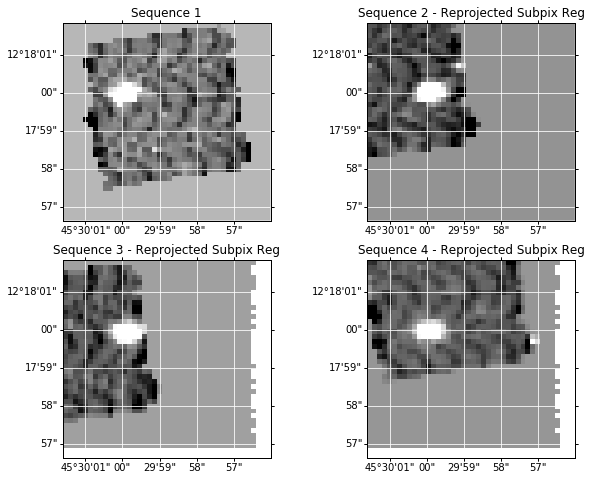

In [13]:
plt.figure(2,  figsize=[10,8])
plt.clf()
plt.subplot(221, projection=ifu1_wcs)
show(ifu1_data, 'Sequence 1')

plt.subplot(222, projection=ifu1_wcs)
show(ifu2_data_reproj_subpix, 'Sequence 2 - Reprojected Subpix Reg')

plt.subplot(223, projection=ifu1_wcs)
show(ifu3_data_reproj_subpix, 'Sequence 3 - Reprojected Subpix Reg')

plt.subplot(224, projection=ifu1_wcs)
show(ifu4_data_reproj_subpix, 'Sequence 4 - Reprojected Subpix Reg')

## Sum Images from Each Method

And finally, now that we have Sequences 2, 3 and 4 reprojected onto 1 and then aligned using several algorithms in the image-registration package, the sum of the 4 dithers can be calculated using the different methods. The first method is reprojection only and no alignment. The cross-correlation, chi2 and subpixel methods are aligned based on a fractional shift using scipy.ndimage.shift.

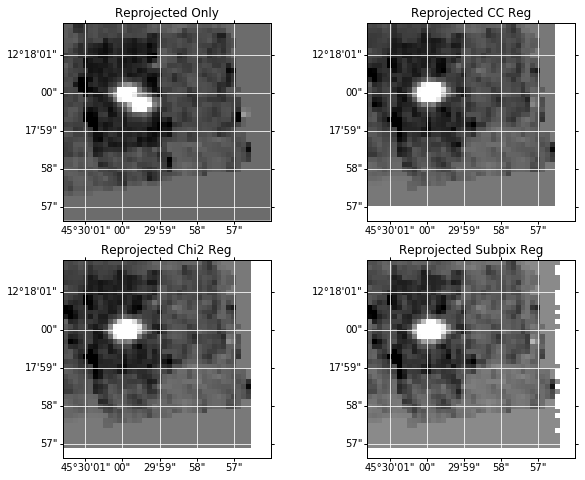

In [14]:
plt.figure(2,  figsize=[10,8])
plt.clf()
plt.subplot(221, projection=ifu1_wcs)
show(ifu1_data + ifu2_data_reproj + ifu3_data_reproj + ifu4_data_reproj, 
     'Reprojected Only')

plt.subplot(222, projection=ifu1_wcs)
show(ifu1_data + ifu2_data_reproj_ccreg + ifu3_data_reproj_ccreg + ifu4_data_reproj_ccreg, 
     'Reprojected CC Reg')

plt.subplot(223, projection=ifu1_wcs)
show(ifu1_data + ifu2_data_reproj_chi2 + ifu3_data_reproj_chi2 + ifu4_data_reproj_chi2, 
     'Reprojected Chi2 Reg')

plt.subplot(224, projection=ifu1_wcs)
show(ifu1_data + ifu2_data_reproj_subpix + ifu3_data_reproj_subpix + ifu4_data_reproj_subpix, 
     'Reprojected Subpix Reg')

Below is a line plot through the 25th row of the original data (blue) and each of the other image registration methods and with the sub-pixel shifting. The width of the peak is simlar to the original dataset so it appears the registration is reasonable.

/Users/crjones/miniconda3/envs/spectral_registration/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


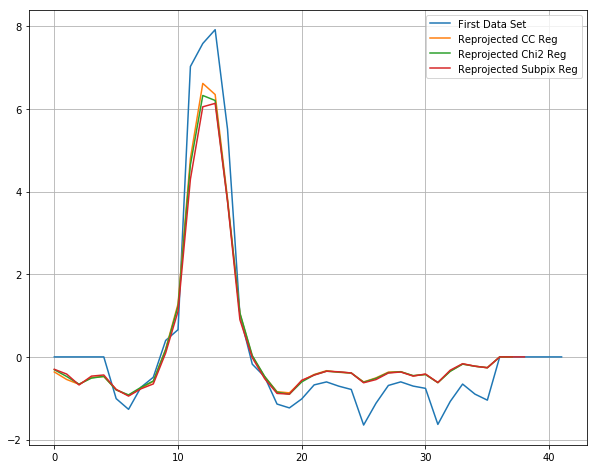

In [16]:
plt.figure(3,  figsize=[10,8])
plt.clf()
plt.plot(ifu1_data[26], label='First Data Set')

tt = (ifu1_data + ifu2_data_reproj_ccreg + ifu3_data_reproj_ccreg + ifu4_data_reproj_ccreg)/4 
plt.plot(tt[26], label='Reprojected CC Reg')

tt = (ifu1_data + ifu2_data_reproj_chi2 + ifu3_data_reproj_chi2 + ifu4_data_reproj_chi2)/4 
plt.plot(tt[26], label='Reprojected Chi2 Reg')

tt = (ifu1_data + ifu2_data_reproj_subpix + ifu3_data_reproj_subpix + ifu4_data_reproj_subpix)/4
plt.plot(tt[26], label='Reprojected Subpix Reg')

plt.grid('on')

plt.legend()